# Choosing a Classification Algorithm

To paraphrase the *no free lunch theorem* proposed by David H. Wolpert, no single classifier works best across all possible scenarios (The Lack of A Priori Distinctions Between Learning Algorithms, Wolpert, David H, Neural Computation 8.7 (1996): 1341-1390). Thus, it is always recommended to compare the performance of a handful of different learning algorithms in order to select the best model for the particular problem. The problem itself may differ in terms of the number of features or examples, the amount of noise in the dataset, and whether the classes are linearly separable, and these factors may influence which learning algorithm performs best.

For now, we will load in the Iris dataset to work with.

In [4]:
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#load in the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

#perform a stratified 70%-30% train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.3,
                                                   random_state=42,
                                                   stratify=y)

#standardize the training features, apply same transformation to test features
ssc = StandardScaler()
X_train_std = ssc.fit_transform(X_train)
X_test_std = ssc.transform(X_test)

# Logistic Regression

Logistic regression is a probabilistic model for binary classification, and it can also be generalized multiclass settings via multinomial logistic regression. The first important concept behind logistic regression is the *odds*, which are the odds in favor of a particular event. If $p$ is the probability of a particular event, then the odds of $p$ are
$$
\frac{p}{1-p}.
$$

In the context of a classification problem, the event we are interested in is the occurence of a "positive class," which means that the training instance in question has $y=1$. Thus, if we let $\mathbf{X}$ denote the feature set, and $\mathbf{x}\in\mathbf{X}$ denotes the features associated with the particular training instance, then we have
$$
p:= \mathbb{P}\{y=1 \mid \mathbf{x} \},
$$
so $p$ represents the conditional probability that a particular training instance belongs to the positive class given its features.

Next, we define the *logit* function, which is the log-odds of the probability $p$, by
$$
\text{logit}(p) = \log\left(\frac{p}{1-p} \right).
$$
The logit function takes input values in the interval $(0, 1)$ and transforms them into values over the entire range of real numbers. Its inverse, the *sigmoid* function, thus maps the real numbers to the interval $[0, 1]$, and is defined by
$$
\sigma(z) = \frac{1}{1+e^{-z}}.
$$
In the logistic regression model, we assume that there is a linear relationship between the log-odds and the weighted input
$$
z = w_1x_1+x_2x_2+\dots+w_mx_m+b = \mathbf{w}^\top\mathbf{x}+b.
$$

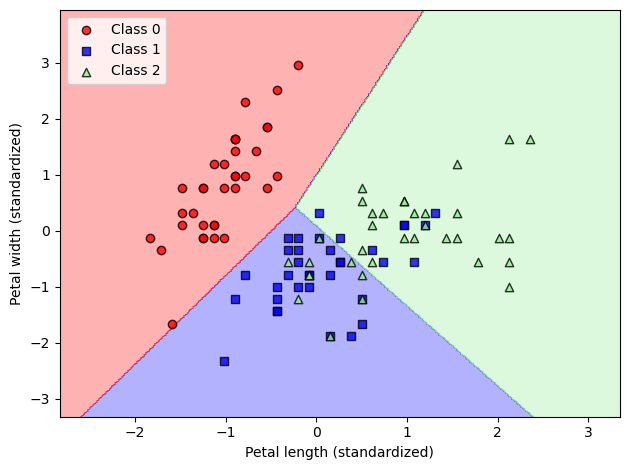

In [11]:
from decision_regions import plot_decision_regions
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

#create logistic regression object and fit to data
lr = LogisticRegression(C=100.0, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std[:, :2], y_train)

#plot decision regions with first two features
plot_decision_regions(X_train_std[:, :2], y_train, classifier=lr)
plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

There are many algorithms available to minimize convex loss functions, such as the logistic regression loss. Those that can be implemented in sklearn via the `solver` parameter include `'newton-cg'`, `'lbfgs'`, `'liblinear'`, `'sag'`, and `'saga'`.

The parameter `C` comes from a convention in support vector machines, and is inversely proportional to the regularization parameter $\lambda$. Thus, decreasing the value of `C` increasess the regularization strength. We can also include a `penalty` for regularization, be it `'l1'`, `'l2'`, or `'elasticnet'` (the default is `'l2'`). However, not every penalty is supported for each solver:

| solver            | penalty                        | multinomial  |
|-------------------|:-------------------------------|------------------------|
| ‘lbfgs’           | ‘l2’, None                     | yes                    |
| ‘liblinear’       | ‘l1’, ‘l2’                     | no                     |
| ‘newton-cg’       | ‘l2’, None                     | yes                    |
| ‘newton-cholesky’ | ‘l2’, None                     | no                     |
| ‘sag’             | ‘l2’, None                     | yes                    |
| ‘saga’            | ‘elasticnet’, ‘l1’, ‘l2’, None | yes                    |

Also note that we can set the `class_weight` parameter to `'balanced'` in order to use the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`.

# Support Vector Machines

When using a support vector machine (SVM), instead of minimizing misclassification error, we instead aim to maximize the *margin*, which is defined as the the distance between the separating hyperplane (decision boundary) and the training examples that are closest to this hyperplane, which are called *support vectors*. The rationale behind having decision boundaries with large margins is that they tend to have a lower generalization error, whereas decision boundaries with small margins are prone to overfitting. While the math behind this is in-depth and requires sound knowledge of constrained optimization, to learn more one can consult:
 - Chris J.C. Burges’ excellent explanation in A Tutorial on Support Vector Machines for Pattern Recognition (Data Mining and Knowledge Discovery, 2(2): 121-167, 1998)
 - Vladimir Vapnik’s book The Nature of Statistical Learning Theory, Springer Science+Business Media, Vladimir Vapnik, 2000
 - Andrew Ng’s very detailed lecture notes available at <https://see.stanford.edu/materials/aimlcs229/cs229-notes3.pdf>
 
In order to control for the bias-variance tradeoff, we often want to employ *soft-margin classification*, wherein we introduce a *slack variable*, which allows the linear constraints in the SVM optimization objective to be relaxed so that the optimization can converge in the presence of misclassifications, which is necessary for non-linearly separable data. The use of the slack variable introduces the hyperparameter $C$ which controls the penalty for misclassification. Decreasing the value of $C$ correponds to smaller error penalties, so we are less strict about misclassification; this increases the bias (underfitting) and lowers the variance (overfitting) of the model.

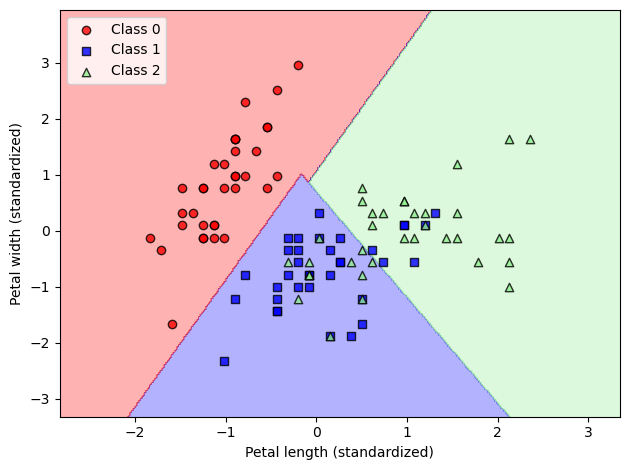

In [16]:
from sklearn.svm import SVC

#create instance of SVC and fit to training data
svm = SVC(kernel='linear', C=10.0, random_state=42)
svm.fit(X_train_std[:, :2], y_train)

#plot decision regions
plot_decision_regions(X_train_std[:, :2], y_train, classifier=svm)
plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

To solve a nonlinear problem using an SVM, we transform the data into a higher-dimensional feature space via a mapping function $\phi$ and train a linear SVM to classify the data in this new feature space. Then, we use the same mapping function $\phi$ to transform new, unseen data into this space and classify it using the linear SVM as well. However, this is computationally expensive. So, instead of computing this new mapping $\phi$, we instead use a *kernel function*, which can essentially be interpreted as a similarity function between a pair of examples. The most widely used kernel is the *radial basis function (RBF)* kernel, which can also be called the *Gaussian kernel*:
$$
\kappa\left(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}\right) = \exp\left(-\frac{\big\lVert \mathbf{x}^{(i)}- \mathbf{x}^{(j)} \big\rVert^2}{2\sigma^2} \right) = \exp\left(-\gamma \big\lVert \mathbf{x}^{(i)}- \mathbf{x}^{(j)} \big\rVert^2 \right),
$$
where $\gamma = (2\sigma^2)^{-1}$ is a hyperparameter to be optimized, and can be understood as cut-off parameter for the Gaussian sphere. If we increase the value of $\gamma$, we increase the influence or reach of the training examples, which leads to a tighter and bumpier decision boundary.

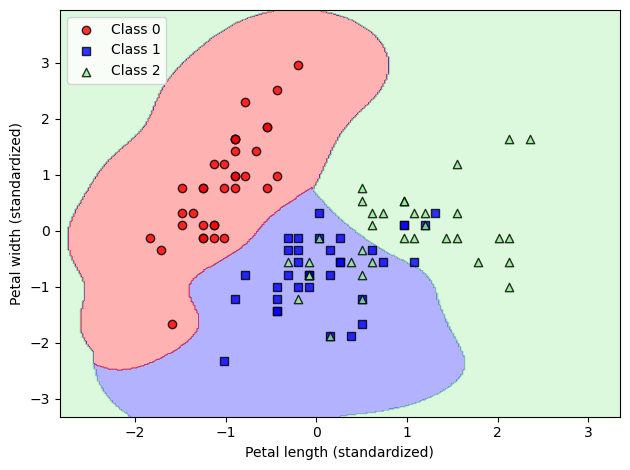

In [27]:
#fit SVC with RBF kernel to the petal data
svm = SVC(kernel='rbf', gamma=2.0, C=1.0, random_state=42)
svm.fit(X_train_std[:, :2], y_train)

#plot decision regions
plot_decision_regions(X_train_std[:, :2], y_train, classifier=svm)
plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Random Forest

The random forest algorithm algorithm uses an ensemble of decision trees. By averaging multiple decision trees that individually suffer from high variance, we can build a more robust model that has a better generalization performance and is less susceptible to overfitting. We can summrize the algorithm as follows:
1. Draw a random bootstrap sample of size $n$ (randomly choose $n$ examples from the training set dataset with replacement).
2. Grow a decision tree from the bootstrap sample. At each node:
    a. Randomly select $d$ features without replacement.
    b. Split the node using the feature that provides the best split according to the objective function, for instance, maximizing the information gain.
3. Repeat steps 1 and 2 $k$ times.
4. Aggregate the prediction by each tree to assign the class label by majority vote.

The algorithm above is implemented in the `RandomForestClassifier` class in sklearn. The hyperparameters that we can optimize for are the number of trees $k$ we create (represented by the `n_estimators` parameter), the number of examples $n$ in each bootstrap sample (represented by the `max_samples` parameter), and the number of features $d$ that are randomly chosen to be considered at each split.

In general, we want to choose as large a value of $k$ as we can afford to computationally. The size of the bootstrap samples $n$ controls the diversity among the individual trees because using a smaller value of $n$ means that the probability of a given example appearing in the bootstrap sample is lower, which  leads to lower variance. However, smaller values of $n$ also lead to higher bias and a lower overall performance. For the number of features $d$ at each split, we want to use a value that's smaller than $m$, the number of features in the training dataset. The default value used is $d=\sqrt{m}$.

We can also choose the criterion used to split the nodes. The default value for the `criterion` parameter is the Gini impurity measure, or `gini`, but we can also choose `entropy` or `log_loss` for the Shannon information gain.

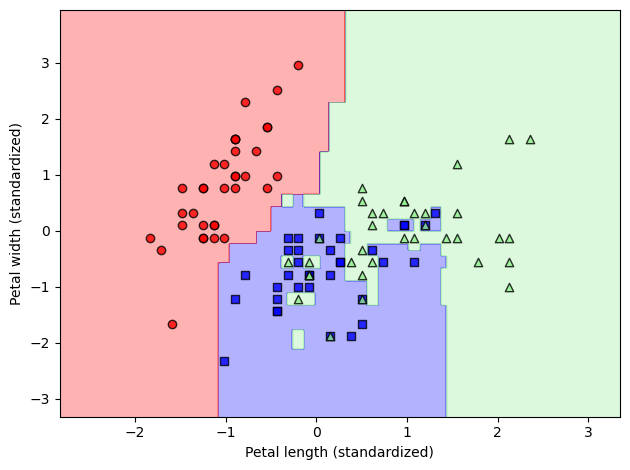

In [28]:
from sklearn.ensemble import RandomForestClassifier

#instantiate RandomForestClassifier object and fit to training data
forest = RandomForestClassifier(n_estimators=25, random_state=42, n_jobs=-1)
forest.fit(X_train_std[:, :2], y_train)

#plot decision regions
plot_decision_regions(X_train_std[:, :2], y_train, classifier=forest)
plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.tight_layout()
plt.show()